# **2_veri_hazirlama**

In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
from IPython.display import display
import os

def github_token_button_clicked(b):
    os.environ["GITHUB_TOKEN"] = "YOUR_GITHUB_TOKEN_HERE"
    print("GitHub Token ortam değişkenine eklendi!")

button1 = widgets.Button(
    description="GitHub Token Ekle",
    button_style='',
    tooltip='GitHub Token Ortam Değişkenine Ekle'
)
button1.on_click(github_token_button_clicked)
display(button1)


Button(description='GitHub Token Ekle', style=ButtonStyle(), tooltip='GitHub Token Ortam Değişkenine Ekle')

GitHub Token ortam değişkenine eklendi!


In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
import os
import datetime
from google.colab import drive
from IPython.display import display

def sync_drive_github(b):
    # Google Drive'ı bağla
    drive.mount('/content/drive', force_remount=True)

    # Git kullanıcı bilgilerini ayarla
    os.system('git config --global user.email "doganzub@gmail.com" > /dev/null 2>&1')
    os.system('git config --global user.name "doganzub" > /dev/null 2>&1')

    # GitHub Token kontrolü
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
    if not GITHUB_TOKEN:
        print("❌ HATA: GitHub Token bulunamadı! Lütfen önce Buton 1 ile ayarlayın.")
        return

    # GitHub repo bağlantısı
    GITHUB_REPO = f"https://{GITHUB_TOKEN}@github.com/doganzub/ml.git"

    # Çalıştırılan notebook'un yolu ve adı (manuel düzenleyin)
    notebook_path = "/content/drive/MyDrive/Colab Notebooks/"
    running_notebook = "2_veri_hazirlama.ipynb"

    # Repo yoksa klonla
    if not os.path.exists("/content/ml"):
        os.system(f"cd /content && git clone {GITHUB_REPO}")

    # Git dizinine geç
    os.chdir("/content/ml")

    # Branch listesini al
    os.system("git fetch --all")
    existing_branches = os.popen("git branch -r").read()

    filename_parts = running_notebook.split("_")
    if not filename_parts[0].isdigit():
        print(f"🚫 {running_notebook} dosyasının başında rakam yok, işlem iptal edildi!")
    else:
        ders_no = filename_parts[0]
        branch_name = f"ders{ders_no}"

        if f"origin/{branch_name}" not in existing_branches:
            print(f"🚫 {branch_name} branch'i GitHub'da bulunamadı, işlem iptal edildi!")
        else:
            os.system(f"git checkout {branch_name}")
            os.system(f'cp "{notebook_path}{running_notebook}" "/content/ml/"')
            commit_message = f"{running_notebook} güncellendi - {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}"
            os.system("git add .")
            status = os.popen("git status --porcelain").read()

            if status.strip():
                os.system(f'git commit -m "{commit_message}"')
                os.system(f"git push origin {branch_name}")
                print(f"✅ {running_notebook} {branch_name} branch'ine yüklendi!")
            else:
                print(f"⚡ {running_notebook} için değişiklik yok, commit atlanıyor!")
            os.system(f'cp -f "/content/ml/{running_notebook}" "{notebook_path}"')

    print("🎯 GitHub ve Google Drive senkronize edildi!")

# Buton 2: Drive & GitHub Senkronizasyonu
button2 = widgets.Button(
    description="Drive & GitHub Senkronizasyonu",
    button_style='',
    tooltip='Google Drive ve GitHub arasında senkronizasyon yap'
)
button2.on_click(sync_drive_github)
display(button2)

Button(description='Drive & GitHub Senkronizasyonu', style=ButtonStyle(), tooltip='Google Drive ve GitHub aras…

# **2.1 Gerekli Kütüphanelerin Yüklenmesi**

### Neden Önemli?
Veri ön işleme aşamasında kullanılacak tüm fonksiyonları, grafik araçlarını ve veri dönüşüm araçlarını bu kütüphaneler sağlar.

### Bu bölümde ne yapacağız?
- **`NumPy, pandas, seaborn, sklearn`** gibi paketleri import edeceğiz.
- **Veri ön işleme** sırasında kullanacağımız fonksiyonları tanımlayacağız.

In [ ]:
import numpy as np                 # Sayısal işlemler
import pandas as pd                # Veri çerçeveleri ile çalışma
import seaborn as sns              # Veri görselleştirme
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  # Kutu grafiği istatistikleri
import random                      # Rastgele işlemler
from random import sample          # Belirli bir listeden rastgele seçim
from sklearn.model_selection import train_test_split  # Eğitim/Test veri bölme
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Normalizasyon & standardizasyon


print("✅ Gerekli kütüphaneler başarıyla yüklendi.")

✅ Gerekli kütüphaneler başarıyla yüklendi.




---



---



---



# **2.2 Veri Okuma**

### Neden Önemli?
Veriyi doğru biçimde okumak ve bir **`DataFrame`** hâline getirmek, sonraki tüm veri ön işleme ve analiz adımları için kritik bir adımdır. Eğer veri yanlış bir konumdan okunursa veya sütun başlıkları hatalı tanımlanırsa, ileriki aşamalarda eksik ya da hatalı sonuçlar alabiliriz.

### Bu bölümde ne yapacağız?
- Google Drive’ı bağlayarak **(`mount`)** veri setinin bulunduğu klasöre erişeceğiz.

- **`auto-mpg.data`** dosyasını, pandas’ın **`read_csv`** fonksiyonunu kullanarak okuyacağız.
- Dosyada başlık **(`header`)** bulunmadığı için names parametresiyle sütun isimlerini manuel tanımlayacağız.
- Veri setinin sütun veri tiplerini **(`dtypes`)**inceleyeceğiz.
- Ayrıca **`head()`** fonksiyonuyla veri içeriğine hızlıca göz atacağız.

In [ ]:
# 1) Google Drive'ı mount ediyoruz
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Sütun isimlerini belirliyoruz
nitelikAdlari = [
    "mpg", "cylinders", "displacement", "horsepower", "weight",
    "acceleration", "model_year", "origin", "car_name"
]

# 3) 'auto-mpg.data' dosyasını, Colab Notebooks klasöründen tam yol ile okuyoruz
veriSeti = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/auto-mpg.data",  # Dosyanın tam yolu
    sep=r"\s+",        # Boşluk veya tab ayracı
    header=None,       # Dosyada sütun başlığı yok
    names=nitelikAdlari,  # Yukarıda tanımlanan sütun isimleri
    decimal="."        # Ondalık ayırıcı
)

# 4) Veri setinin boyutu ve sütun veri tipleri
print("Sütun Veri Tipleri:\n", veriSeti.dtypes)
display(veriSeti.head(10))

Mounted at /content/drive
Sütun Veri Tipleri:
 mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl





---


---



---



# **2.3 Eksik Veri Tamamlama (Missing Data Imputation)**

### Neden Önemli?
Eksik veriler, modelin doğruluğunu olumsuz etkileyebilir veya hata oluşturabilir. Bu nedenle eksik verileri uygun yöntemlerle doldurmak **(`imputation`)**, veri kalitesini artırır ve analiz veya makine öğrenmesi modellerinden daha güvenilir sonuçlar elde etmemize yardımcı olur.

### Bu bölümde ne yapacağız?
- **`horsepower`** sütunundaki **'?'** karakterlerini **`NaN`’e** dönüştüreceğiz.
- Bu sütunun veri tipini sayısal **`(float64)`** hâline getireceğiz.
- Eksik veri sayısını inceleyip, ortalama değerle dolduracağız.
- **`fillna()`** metodu kullanımını örnek olarak göreceğiz.

In [ ]:
soru_isareti_sayisi = (veriSeti["horsepower"] == "?").sum()       # Ön kontrol: horsepower sütununda "?" karakteri var mı?
print("horsepower sütununda '?' sayısı:", soru_isareti_sayisi)    # Bu satır, "?" işareti olan satırların sayısını ekrana basar.

# 1) '?' karakterini NaN'e dönüştürme
veriSeti.loc[veriSeti.horsepower == "?", "horsepower"] = np.nan   # loc[] fonksiyonu, koşul ile belirtilen satırlara erişmemizi sağlar.
                                                                  # horsepower sütununda "?" görülen hücreleri NaN (eksik değer) işaretleme.
# 2) 'horsepower' sütununun tipini float64'e dönüştürme
veriSeti.horsepower = veriSeti.horsepower.astype("float64")       # astype("float64"), sütun tipini sayısal hale getirir.

# 3) Eksik veri sayısını (ilk kontrol) ekrana bastırma
print("Eksik Veri Sayısı (Önce):\n", veriSeti.isnull().sum())     # isnull().sum(), sütun bazında NaN sayısını verir.

# 4) fillna() metodu ile ortalamayla doldurma
veriSeti["horsepower"].fillna(
    veriSeti["horsepower"].mean().round(0),                       # mean().round(0), sütunun ortalamasını en yakın tam sayıya yuvarlar.
    inplace=True                                                  # inplace=True, değişikliği doğrudan veriSeti üzerinde uygular.
)
print("Eksik Veri Sayısı (Sonra):\n", veriSeti.isnull().sum())    # Eksik veri sayısını tekrar kontrol ediyoruz

horsepower sütununda '?' sayısı: 6
Eksik Veri Sayısı (Önce):
 mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64
Eksik Veri Sayısı (Sonra):
 mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


<ipython-input-5-74ef94727ea1>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  veriSeti["horsepower"].fillna(




---



---



---



# **2.4 Veri Ayırıklaştırma (Binning / Discretization)**

### Neden Önemli?
- Sürekli (sayısal) veriler, kategorik (gruplandırılmış) değerlere dönüştürülür.
- Bu dönüşümle, veriye yeni bir sütun eklenir veya mevcut sütun sınıflara ayrılır.
- Amaç: Sayısal değerleri daha anlamlı ve genellenmiş kategorilere indirgemektir.

Örneğin: `mpg` değişkeni;
- **23.5’in altında** ise → **Düşük**
- **23.5 – 30 arası** ise → **Orta**
- **30 ve üstü** ise → **Yüksek** olarak sınıflandırılabilir.

Bu işlem sonucunda:
- Veri setine **yeni bir kategorik sütun (örneğin: `durum`)** eklenir.
- Satır sayısı değişmez; sadece her satır bir kategoriye atanır.

---

### Bu bölümde ne yapacağız?
- `mpg` sütununu **Düşük**, **Orta** ve **Yüksek** kategorilerine ayıracağız.
- Dört farklı yöntemle ayrıklaştırma işlemi gerçekleştireceğiz:

I. Yöntem:

 **1.** **`lambda` + `map()`** fonksiyonu ile manuel koşullu sınıflandırma yapacağız.  

II. Yöntem:

**2.1.** **`pd.cut()`** fonksiyonu ile **sabit aralık (fixed interval)** yöntemi uygulayacağız.  
**2.2.** **`pd.qcut()`** fonksiyonu ile **eşit frekans (quantile)** yöntemi kullanacağız.  
**2.3.** **`pd.cut()`** fonksiyonu ile **eşit genişlik (equal interval)** yöntemini uygulayacağız.


Her yöntemde amaç, `mpg` değerlerini farklı sınıflandırma stratejileriyle gruplandırmak ve analizlerde kullanılabilecek kategorik yapılar oluşturmaktır.


In [ ]:
# ------------------------------------------------------------
# I. Yöntem: lambda + map
# ------------------------------------------------------------
# lambda ifadesi, 'mpg' değerine göre koşullu atama yapar:
# - x < 23.5 ise "Düşük"
# - 23.5 <= x < 30 ise "Orta"
# - x >= 30 ise "Yüksek" olarak etiketler.
veriSeti["durum"] = veriSeti.mpg.map(
    lambda x: "Düşük" if x < 23.5 else ("Orta" if (x >= 23.5 and x < 30) else "Yüksek")
).astype("category")

print("Durum (lambda) dağılım:\n", veriSeti.durum.value_counts())
print(f"\n{'-'*82}\n")

#----------------------------------------------------------------------------------
# II. Yöntem:
#----------------------------------------------------------------------------------

# II.1: Yöntem: Fixed (sabit) aralıklarla bölme
bolmeKategorileri = ["Düşük", "Orta", "Yüksek"]   # önceden belirlenmiş sınırlar kullanılarak 'mpg' değerleri üç kategoriye ayrılır.
bolmeler = [8, 23.4, 29.9, 46.6]                  # Belirlenen sınırlar
veriSeti["durum"] = pd.cut(
    veriSeti["mpg"],
    bins=bolmeler,
    labels=bolmeKategorileri
)
print("Durum (fixed cut) dağılım:\n", veriSeti.durum.value_counts())
print(f"\n{'-'*82}\n")

# II.2: Yöntem: Equal Frequency (qcut)
durum_ef = pd.qcut(veriSeti["mpg"], q=3)        # 'mpg' değerleri yaklaşık eşit sayıda gözlem içerecek şekilde üç gruba ayrılır.

print("Durum (Eşit frekans) dağılım:\n", durum_ef.value_counts())
print(f"\n{'-'*82}\n")

# II.3: Yöntem: Equal Interval (eşit genişlik)
durum_ea = pd.cut(veriSeti["mpg"], bins=3)      # 'mpg' değerlerinin aralığı eşit genişlikli üç dilime bölünür.
print("Durum (Eşit frekans) dağılım:\n", durum_ea.value_counts())
print(f"\n{'-'*82}\n")

Durum (lambda) dağılım:
 durum
Düşük     208
Orta       98
Yüksek     92
Name: count, dtype: int64

----------------------------------------------------------------------------------

Durum (fixed cut) dağılım:
 durum
Düşük     208
Orta       98
Yüksek     92
Name: count, dtype: int64

----------------------------------------------------------------------------------

Durum (Eşit frekans) dağılım:
 mpg
(8.999, 19.0]     143
(26.933, 46.6]    133
(19.0, 26.933]    122
Name: count, dtype: int64

----------------------------------------------------------------------------------

Durum (Eşit frekans) dağılım:
 mpg
(8.962, 21.533]     183
(21.533, 34.067]    171
(34.067, 46.6]       44
Name: count, dtype: int64

----------------------------------------------------------------------------------





---



---



---



# **2.5 Veri Seti Özeti (describe)**

### Neden Önemli?
Veri setinin genel istatistiksel özelliklerini (ortalama, std, min, max vb.) görmek, veri hakkında hızlıca fikir sahibi olmamızı sağlar. Hem sayısal hem de kategorik sütunların özetini almak, veri analizinin sonraki adımlarını planlamada bize rehberlik eder.

### Bu bölümde ne yapacağız?
- pd.set_option("display.max_columns", 20) ayarıyla, DataFrame ekrana basılırken en fazla kaç sütun gösterileceğini belirleyeceğiz.

- veriSeti.describe(include="all") fonksiyonunu kullanarak, tüm sütunların (sayısal ve kategorik) temel istatistiksel özetini görüntüleyeceğiz.

In [ ]:
# 1) pd.set_option ile ekrana basılacak sütun sayısını 20 ile sınırlıyoruz
pd.set_option("display.max_columns", 20)

# 2) describe(include="all") ile sayısal ve kategorik tüm sütunların özet istatistiklerini alıyoruz
print("Veri Seti Özeti (describe, include='all'):\n", veriSeti.describe(include="all"))


Veri Seti Özeti (describe, include='all'):
                mpg   cylinders  displacement  horsepower       weight  \
count   398.000000  398.000000    398.000000  398.000000   398.000000   
unique         NaN         NaN           NaN         NaN          NaN   
top            NaN         NaN           NaN         NaN          NaN   
freq           NaN         NaN           NaN         NaN          NaN   
mean     23.514573    5.454774    193.425879  104.462312  2970.424623   
std       7.815984    1.701004    104.269838   38.199230   846.841774   
min       9.000000    3.000000     68.000000   46.000000  1613.000000   
25%      17.500000    4.000000    104.250000   76.000000  2223.750000   
50%      23.000000    4.000000    148.500000   95.000000  2803.500000   
75%      29.000000    8.000000    262.000000  125.000000  3608.000000   
max      46.600000    8.000000    455.000000  230.000000  5140.000000   

        acceleration  model_year      origin    car_name  durum  
count     398

# **2.6 Veri Gruplandırma (Aggregate)**

### Neden Önemli?
Makine öğrenmesi ve veri bilimi süreçlerinde, bazen tüm veri setini tek bir bütün olarak değerlendirmek yerine, verileri belirli özelliklere göre alt gruplara ayırıp ayrı ayrı incelemek faydalıdır. Bu işlem sayesinde her bir alt grup hakkında istatistiksel özet bilgiler elde edebiliriz. Bu, veriyi anlamak, farklı alt grupları karşılaştırmak ve karar vermek açısından önemlidir.

**Örneğin:** Bir otomobil verisinde araçların yakıt tüketimini (mpg) "durum" kategorisine (Düşük, Orta, Yüksek) göre ayrı ayrı inceleyebilirsiniz. Böylece her grubun yakıt tüketim özelliklerini ayrı ayrı değerlendirebilirsiniz.


### **Veri Ayrıklaştırma ile Gruplandırma Arasındaki Fark**

**Veri Ayrıklaştırma (Discretization) = sayısalı kategorik hale getirme**
- **Amaç:** Sürekli değişkenleri kategorik hale getirerek sınıflandırmak.
- **Ön koşul:** Kategorik bir sütun yoksa, analiz için kendimiz üretmeliyiz.

**Veri Gruplandırma (Aggregation) = zaten var olan kategorik değişkene göre istatistik çıkarmak**
- **Amaç:** Var olan kategorik sütuna göre gruplar oluşturup bu gruplar için istatistikler hesaplamak.
- **Ön koşul:** Veri setinde zaten kategorik bir değişken (örneğin durum) varsa doğrudan kullanılabilir.r.



### Bu bölümde ne yapacağız?
- **groupby("durum")** ifadesini kullanarak, durum sütunu bazında veri setini gruplara ayıracağız.

- Farklı toplulaştırma fonksiyonları **(mean, sum, count, min, max, std, describe)** ile her bir kategorinin temel istatistiklerini görüntüleyeceğiz.

In [ ]:
# 1. Adım: "durum" kategorisine göre "mpg" değişkeninin temel istatistiklerini çıkar
df_ozet = veriSeti.groupby("durum")["mpg"].describe().round(2)

# 2. Adım: 'durum' değişkeni indeks olarak değil, sütun olarak görünsün diye resetlenir
df_ozet.reset_index(inplace=True)

# 3. Adım: Jupyter defteri kullanılıyorsa tablo şeklinde görselleştir
display(df_ozet)  # Sadece Jupyter ortamında çalışır. Eğer konsoldaysanız print(df_ozet) yazmalısınız.




<ipython-input-18-69c01bd7f52e>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ozet = veriSeti.groupby("durum")["mpg"].describe().round(2)


,durum,count,mean,std,min,25%,50%,75%,max
0,Düşük,208.0,17.26,3.35,9.0,14.38,17.55,20.00,23.2
1,Orta,98.0,26.34,1.78,23.5,25.00,26.00,28.00,29.9
2,Yüksek,92.0,34.63,3.83,30.0,31.88,33.90,36.55,46.6


## 📊 `durum` Değişkenine Göre `mpg` (Yakıt Verimliliği) İstatistikleri

Aşağıdaki tablo, `mpg` (mil per galon) sayısal değişkeninin, `durum` adlı kategorik değişkene göre gruplandırılarak (aggregation) temel istatistiklerle özetlenmesini göstermektedir.

| Kategori (`durum`) | Gözlem | Ortalama | Std. Sapma | Min  | Q1 (%25) | Medyan (%50) | Q3 (%75) | Max  |
|--------------------|--------|----------|------------|------|----------|---------------|----------|------|
| **Düşük**          | 208    | 17.26    | 3.35       | 9.0  | 14.38    | 17.55         | 20.00    | 23.2 |
| **Orta**           | 98     | 26.34    | 1.78       | 23.5 | 25.00    | 26.00         | 28.00    | 29.9 |
| **Yüksek**         | 92     | 34.63    | 3.83       | 30.0 | 31.88    | 33.90         | 36.55    | 46.6 |

---


### Yorum:

1. **Yüksek** `durum` kategorisi:
   - En yüksek **ortalama** `mpg` değeriyle (`34.63`) en verimli gruptur.
   - Aynı zamanda **en geniş aralığa** (min: 30.0 – max: 46.6) sahip → Bu grupta farklı düzeylerde yüksek verimliliğe sahip araçlar bulunur.

2. **Orta** kategori:
   - **En düşük standart sapmaya** (`1.78`) sahiptir → Değerler birbirine çok yakındır, grup oldukça **homojen**dir.
   - Ortalama (`26.34`) ve medyan (`26.00`) birbirine çok yakındır → Dağılım simetrik olabilir.

3. **Düşük** kategori:
   - Ortalama değer (`17.26`) en düşük olan gruptur.
   - Standart sapmanın (`3.35`) yüksek olması → Gruptaki araçlar arasında önemli **çeşitlilik** vardır.
   - Alt çeyrek (`Q1 = 14.38`) ve üst çeyrek (`Q3 = 20.00`) arasındaki mesafe daha büyüktür → Daha yaygın ve düzensiz bir dağılım gösterir.

---
---






---



---



---



# **2.7 Tekrarlayan Satırların Bulunması (Duplicated Rows)**

### Neden Önemli?
Tekrarlayan **(duplicate)** satırlar, veri analizi sonuçlarını yanıltabilir. Aynı gözlemin veri setinde birden fazla kez yer alması, ortalama ve diğer istatistiksel hesaplamaları etkileyerek hatalı sonuçlara yol açabilir. Bu nedenle tekrarlayan satırları tespit edip, gereksiz olanları temizlemek veri kalitesini artırır.

### Bu bölümde ne yapacağız?
- `duplicated()` fonksiyonunu kullanarak tekrarlayan satırları bulacağız.
- `drop_duplicates()` ile tekrarlayanları temizleyeceğiz.
- Tekrarlayan satırları bulmak için farklı keep parametreleri **(örneğin "first", "last")** deneyeceğiz.

In [ ]:
# 1) duplicated(keep="first") ve duplicated(keep="last") ile tekrarlayan satırları tespit ediyoruz
    # keep="first" => ilk tekrar eden satırı False, diğer tekrarlarını True olarak işaretler
    # keep="last"  => son tekrar eden satırı False, diğer tekrarlarını True olarak işaretler
tekrarlar_f = veriSeti.duplicated(keep="first")
tekrarlar_l = veriSeti.duplicated(keep="last")

# 2) Herhangi birinin True olduğu satırlar, tekrarlayan satırlardır
indislerim = tekrarlar_f | tekrarlar_l

# 3) Tekrarlayan gözlemleri ekrana basalım
print("Tekrarlayan Gözlemler:\n", veriSeti[indislerim])

# 4) drop_duplicates() ile veri setinden tekrar eden satırları kaldırıyoruz
veriSeti2 = veriSeti.drop_duplicates()

# 5) Kaldırma işleminden sonra veri setinin boyutunu (shape) inceleyerek değişikliği gözlemleyebiliriz
print("\nTekrarlayanlardan arındırılmış veriSeti2 shape:", veriSeti2.shape)


Tekrarlayan Gözlemler:
 Empty DataFrame
Columns: [mpg, cylinders, displacement, horsepower, weight, acceleration, model_year, origin, car_name, durum]
Index: []

Tekrarlayanlardan arındırılmış veriSeti2 shape: (398, 10)


# **2.8 Aykırı Değer Analizi (IQR ve Boxplot)**

### Aykırı Değer Nedir?

Aykırı değer, veri setindeki diğer değerlerden **belirgin şekilde uzak** olan gözlemlerdir.  
Bu değerler çoğu zaman hatalı girişler, ölçüm hataları veya sıra dışı durumları temsil edebilir.

> Örnek: Eğer `horsepower` sütunundaki değerlerin çoğu 50–150 arasında ise, 230 gibi bir değer aykırı olabilir.

---

### Neden Önemlidir?

- Aykırı değerler analizlerin sonucunu **yanıltabilir**.
- Ortalama, standart sapma gibi istatistikleri bozar.
- Bazı algoritmalar (örneğin KNN, k-means) aykırı değerlerden çok etkilenir.

---

### Aykırı Değer Nasıl Bulunur?

**1. Görsel yöntem:** Kutu grafiği (boxplot)  
**2. İstatistiksel yöntem:** IQR (Interquartile Range) yöntemi
Bu derste, `horsepower` değişkenini örnek alarak hem istatistiksel hem görsel yöntemle aykırı değerleri belirleyeceğiz.








In [ ]:
# 1. Kartil (Q1) ve 3. Kartil (Q3) değerlerini hesaplayalım
q1 = veriSeti["horsepower"].quantile(0.25)  # Alt %25'lik değeri temsil eder
q3 = veriSeti["horsepower"].quantile(0.75)  # Üst %25'lik değeri temsil eder

# IQR (çeyrekler arası açıklık): Q3 - Q1
IQR = q3 - q1

# Alt ve üst sınırları belirliyoruz
alt = q1 - 1.5 * IQR
ust = q3 + 1.5 * IQR

print(f"Aykırı değer alt sınırı: {alt}, üst sınırı: {ust}")


Aykırı değer alt sınırı: 2.5, üst sınırı: 198.5


In [ ]:
# Aykırı olan satırların indekslerini buluyoruz
ust_aykiriDegerInd = np.where(veriSeti["horsepower"] >= ust)[0]   # Üst sınırın üzerindeki indeksler
alt_aykiriDegerInd = np.where(veriSeti["horsepower"] <= alt)[0]   # Alt sınırın altındaki indeksler

# Üst sınırın üzerindeki aykırı değerleri indeks : değer formatında yazdırıyoruz
print("Üst sınırın üzerindeki aykırı değerler:")
for i in ust_aykiriDegerInd:
    print(f"İndeks: {i}, Değer: {veriSeti['horsepower'][i]}")

# Alt sınırın altındaki aykırı değerleri indeks : değer formatında yazdırıyoruz
print("\nAlt sınırın altındaki aykırı değerler:")
for i in alt_aykiriDegerInd:
    print(f"İndeks: {i}, Değer: {veriSeti['horsepower'][i]}")


Üst sınırın üzerindeki aykırı değerler:
İndeks: 6, Değer: 220.0
İndeks: 7, Değer: 215.0
İndeks: 8, Değer: 225.0
İndeks: 13, Değer: 225.0
İndeks: 25, Değer: 215.0
İndeks: 26, Değer: 200.0
İndeks: 27, Değer: 210.0
İndeks: 67, Değer: 208.0
İndeks: 94, Değer: 215.0
İndeks: 95, Değer: 225.0
İndeks: 116, Değer: 230.0

Alt sınırın altındaki aykırı değerler:


### 📊 Kutu Grafiği

- **Kutu grafiği (boxplot)**, verinin dağılımını ve olası aykırı değerleri görsel olarak anlamamızı sağlar.
- Orta çizgi: **Ortanca (medyan)**
- Kutunun alt ve üst kenarları: **1. ve 3. çeyrek (Q1, Q3)**
- Alt ve üst "bıyık" çizgileri:
  - Alt sınır = Q1 - 1.5 * IQR
  - Üst sınır = Q3 + 1.5 * IQR
- Bu sınırların **dışındaki daireler**, **aykırı değerleri** gösterir.

Bu grafik sayesinde:
- Hangi değerlerin aykırı olduğunu görselleştiririz.
- Alt sınırın altında aykırı değer olup olmadığını,
- Üst sınırın üzerinde ne kadar aykırı değer olduğunu kolayca gözlemleyebiliriz.


<ipython-input-11-c5b0639b4fe3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="horsepower", data=veriSeti, palette="magma")


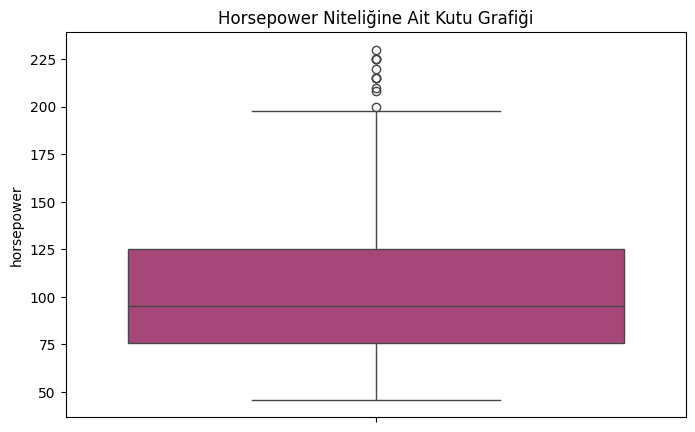

In [ ]:
# 1️⃣ Basit Kutu Grafiği

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y="horsepower", data=veriSeti, palette="magma")
plt.title("Horsepower Niteliğine Ait Kutu Grafiği")
plt.show()


In [1]:
#@title 2️⃣ Açıklamalı Kutu Grafiği

plt.figure(figsize=(10, 7))

# Aykırı değerleri gizleyerek kutu grafiği çiz
sns.boxplot(y="horsepower", data=veriSeti, palette="magma", showfliers=False)
plt.title("Gerçek Verilerle Horsepower Değişkenine Ait Açıklamalı Kutu Grafiği")

# İstatistik değerleri
ortalama = veriSeti["horsepower"].mean()
medyan = veriSeti["horsepower"].median()
q1 = veriSeti["horsepower"].quantile(0.25)
q3 = veriSeti["horsepower"].quantile(0.75)
iqr = q3 - q1Æ
alt = q1 - 1.5 * iqÆr
ust = q3 + 1.5 * iqr

# Ortalama (turuncu)
plt.plot([0], [ortalama], "o-", color="orange")
plt.text(0.1, ortalama, f"Ortalama:\n{ortalama:.2f}", color="orange", fontsize=10)

# Medyan (siyah nokta)
plt.plot(0, medyan, "ko")
plt.text(-0.35, medyan, f"Medyan\n{medyan:.2f}", fontsize=10)

# Q1
plt.plot(0, q1, "ks")
plt.text(-0.35, q1, f"Q1 (Alt Çeyrek)\n{q1:.2f}", fontsize=9)

# Q3
plt.plot(0, q3, "ks")
plt.text(-0.35, q3, f"Q3 (Üst Çeyrek)\n{q3:.2f}", fontsize=9)

# Alt sınır (mavi kare)
plt.plot(0, alt, "bs")
plt.text(0.15, alt + 2, f"Alt Sınır\n{alt:.2f}", color="blue", fontsize=9)

# Üst sınır (mavi kare)
plt.plot(0, ust, "bs")
plt.text(0.15, ust + 2, f"Üst Sınır\n{ust:.2f}", color="blue", fontsize=9)

# Aykırı değerler (siyah daire)
for i, val in enumerate(veriSeti["horsepower"]):
    if val > ust or val < alt:
        plt.plot(0, val, "ko")
        x_offset = 0.2 if i % 2 == 0 else 0.25
        plt.text(x_offset, val, f"{val:.1f}", fontsize=8, color="black")

plt.ylabel("Horsepower")
plt.xticks([])
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# 4) Aykırı değerleri kaldırmak için aşağıdaki satırları yorumdan çıkarabilirsiniz
# veriSeti.drop(index=ust_aykiriDegerInd, inplace=True)
# veriSeti.drop(index=alt_aykiriDegerInd, inplace=True)



# **2.9 Örnekleme (Sampling ve Stratified Sampling)**

##2.9.1. Rastgele Örnekleme (Random Sampling)
bir veri kümesinden rastgele olarak veri noktaları seçmeyi ifade eder. Her bir veri noktasının seçilme şansı eşittir.
- **1'den 20'**ye kadar olan sayılar arasında rastgele **5** sayı seçmek istiyorsanız, bu sayılar her seferinde farklı olabilir.
- Örneğin: **[15, 6, 9, 14, 5]** ve başka bir seçimde farklı sayılar olabilir: **[16, 1, 17, 14, 10]**.

In [ ]:
# 1'den 20'ye kadar sayılar
listem = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# diğer yol:  # listem = list(np.arange(1, 21))

# Rastgele 5 sayı seçimi
# sample() fonksiyonu ile her çağrıda farklı rastgele elemanlar seçilir ve tekrar eden sayı bulunmaz.
print("Örnek Seçim 1:", sample(listem, 5))
print("Örnek Seçim 2:", sample(listem, 5))


Örnek Seçim 1: [15, 8, 2, 6, 4]
Örnek Seçim 2: [12, 16, 8, 13, 4]


## 2.9.2. Sabit Tohumlu Rastgele Örnekleme (Seeded Sampling)
Rastgele örnekleme, her çalıştırıldığında farklı sonuçlar üretir. Ancak bazen belirli bir sonucu tekrarlamak isteriz. Bunun için bir "tohum" (seed) değeri kullanılır. Aynı tohum değeriyle rastgele seçim yapılırsa, her seferinde aynı seçimler elde edilir.

- raporlar yazarken ya da tekrarlanabilirlik isteyen deneyler yaparken faydalıdır.

In [ ]:
# Aynı seed ile benzer sonuçlar
random.seed(123)                                          # Algoritma için başlangıç noktasını (başlangıç değerini) 123 olarak belirler.
                                                          # Bu noktadan itibaren rastgele sayılar üretir.
print("Örnek Seçim 3 (seed=123):", sample(listem, 5))
random.seed(123)
print("Örnek Seçim 4 (seed=123):", sample(listem, 5))

random.seed(5)                                            # 5 yazarsanız başlangıç noktası (tohum değeri) değişir, dolayısıyla farklı sayılar üretirsiniz.
print("Örnek Seçim 5 (seed=5):", sample(listem, 5))
random.seed(5)
print("Örnek Seçim 6 (seed=5):", sample(listem, 5))


Örnek Seçim 3 (seed=123): [2, 9, 3, 14, 19]
Örnek Seçim 4 (seed=123): [2, 9, 3, 14, 19]
Örnek Seçim 5 (seed=5): [20, 9, 12, 17, 1]
Örnek Seçim 6 (seed=5): [20, 9, 12, 17, 1]


## 2.9.3. Yerine Koyarak Seçim (Sampling with Replacement)
Veri kümesindeki bir öğe birden fazla kez seçilebilir ve her seçimde aynı öğe tekrar kullanılabilir.
- Bir kutuda 10 top olduğunu düşünün. Bu kutudan 3 top seçiyorsunuz, ancak her seferinde topu kutuya geri koyuyorsunuz. Bu durumda aynı topu tekrar seçebilirsiniz.

In [ ]:
# Yerine koyarak seçim
print("Yerine koyarak seçim:", random.choices(listem, k=10))


Yerine koyarak seçim: [2, 7, 13, 1, 14, 7, 7, 17, 10, 7]


##2.9.4. Eğitim ve Test Veri Seti Oluşturma
Eğitim ve test veri seti oluşturma, model eğitimi ve doğrulama işlemleri için veriyi ayırma işlemidir.
 - Genellikle verinin **%70'i eğitim seti**, **%30'u ise test seti** olarak ayrılır.
 - Eğitim seti, makine öğrenmesi modelinin eğitilmesi için kullanılırken, test seti modelin doğruluğunu ve başarısını değerlendirmek için kullanılır.

In [ ]:
egitim = veriSeti.sample(frac=0.7, replace=False, random_state=1)
      # sample(): Veri setinden rastgele örnekleme yapar.
      # frac=0.7 → veri setinin %70'ini seç,
      # replace=False → aynı satır birden fazla kez seçilmesin (tekrarsız seçim),
      # random_state=1 → her çalıştırmada aynı satırların seçilmesini sağlar (tekrarlanabilirlik için sabit tohum değeri)

ind = veriSeti.index.isin(egitim.index)
      # isin(): Eğitim setindeki index’lerin ana veri setinde olup olmadığını kontrol eder.
      # Sonuç olarak True/False değerlerinden oluşan bir dizi döner.

test = veriSeti[~ind]
      # ~ind: Eğitim setine dahil olmayan (False olan) satırları seçer.
      # Böylece kalan %30’luk kısım test setini oluşturur.

print("Eğitim Seti Boyutu:", egitim.shape)
    # shape: Seçilen veri çerçevesinin (DataFrame) satır ve sütun sayısını verir.

print("Test Seti Boyutu:", test.shape)

Eğitim Seti Boyutu: (279, 10)
Test Seti Boyutu: (119, 10)


##2.9.5. Tabakalı Örnekleme (Stratified Sampling)
Tabakalı örnekleme, verinin belirli gruplara (tabakalara) ayrılarak her gruptan orantılı bir şekilde örnekleme yapılmasıdır. Özellikle dengesiz veri setlerinde, her sınıfın doğru bir şekilde temsil edilmesini sağlar.

- Tüm veri setindeki sınıf oranı → eğitim ve test setine eşit şekilde dağılır.
- Model eğitiminde azınlık sınıfların ihmal edilmesi önlenir.
- Eğitim ve test setlerinde "durum" değişkeninin dağılımı korunur.

Örneğin:
- Tüm veride **"Düşük: 208, Orta: 98, Yüksek: 92"** varsa,
- Eğitim setinde → **Düşük: 145, Orta: 69, Yüksek: 64**
- Test setinde → **Düşük: 63, Orta: 29, Yüksek: 28** şeklinde benzer oranlar korunur.

In [ ]:
egitim1, test1 = train_test_split(                         # train_test_split(): veri setini eğitim ve test setine ayırır
    veriSeti,                                              # veriSeti: bölünecek veri
    train_size=0.7,                                        # train_size=0.7 → verinin %70’i eğitim, %30’u test olacak şekilde ayır
    stratify=veriSeti["durum"],                            # stratify: "durum" değişkenine göre orantılı örnekleme yapılır
    random_state=1                                         # random_state=1 → aynı sonucu almak için sabit tohum (seed)
)

print("\nDurum Dağılımı (Tüm veri):\n", veriSeti.durum.value_counts())    # value_counts(): "durum" değişkeninin sınıf dağılımını gösterir
print("\nDurum Dağılımı (Eğitim seti):\n", egitim1.durum.value_counts())  # Eğitim setindeki sınıf dağılımını yazdırır
print("\nDurum Dağılımı (Test seti):\n", test1.durum.value_counts())      # Test setindeki sınıf dağılımını yazdırır



Durum Dağılımı (Tüm veri):
 durum
Düşük     208
Orta       98
Yüksek     92
Name: count, dtype: int64

Durum Dağılımı (Eğitim seti):
 durum
Düşük     145
Orta       69
Yüksek     64
Name: count, dtype: int64

Durum Dağılımı (Test seti):
 durum
Düşük     63
Orta      29
Yüksek    28
Name: count, dtype: int64


# **2.10 Yapay Kodlama (Label and Dummy Coding) ve Veri Normalizasyonu**

 ### 2.10.1. Kategorik Değişkeni Sayısal Forma Dönüştürme (cat.codes ve get_dummies)
 #### Neden Önemli?
Makine öğrenmesi ve istatistiksel modeller **sayısal verilerle çalışır**. Bu yüzden kategorik değişkenleri sayısal forma çevirmemiz gerekir.  
Bu işlem genellikle iki yöntemle yapılır:

---

#### 1️⃣ `cat.codes` → Label Encoding (Etiket Kodlama)

- Her kategoriye bir **sayısal değer** atanır.
- Tek bir sütun oluşturur.
Örnek:

| durum   | durum_s1 |
|---------|----------|
| Düşük   | 0        |
| Orta    | 1        |
| Yüksek  | 2        |

- ✅ Basit ve tek sütunludur.

---

#### 2️⃣ `get_dummies()` → Dummy (One-Hot) Encoding

- Her kategori için **ayrı bir sütun** oluşturur.
- 0 ve 1 değerleri içerir.
Örnek:

| Düşük | Orta | Yüksek |
|-------|------|--------|
| 1     | 0    | 0      |
| 0     | 1    | 0      |
| 0     | 0    | 1      |

- ✅ Her kategoriyi eşit ve bağımsız olarak gösterir.
- Özellikle **regresyon, mesafe temelli modeller** için daha uygundur.

---

#### Projede Neden Her İkisi de Kullanıldı?

Kodda hem `cat.codes` hem de `get_dummies()` kullanıldı. Bu sayede:

- `durum_s1` sütunu: **etiket kodlama** için,
- `Düşük`, `Orta`, `Yüksek` sütunları: **dummy kodlama** için oluşturulmuş oldu.

**Hangisi kullanılacak?**  
➡️ Modeliniz sıralı bilgiye ihtiyaç duymuyorsa dummy encoding daha güvenlidir.

---

✅ **Sonuç:**  
Kategorik veriyi sayısala çevirmek zorunludur. Ancak **nasıl çevireceğiniz**, kullandığınız algoritmaya bağlıdır.


In [ ]:
# Kategorik değişkeni sayısal forma dönüştürme
# 1️⃣ (cat.codes)
veriSeti["durum_s1"] = veriSeti["durum"].cat.codes                      # Kategorik 'durum' değişkenini 0,1,2 gibi sayılara çevir
print("durum_s1 değer dağılımı:", veriSeti["durum_s1"].value_counts())  # Sayısal karşılıkların frekansını yazdır

# 2️⃣ (get_dummies()
if not {'Düşük', 'Orta', 'Yüksek'}.issubset(veriSeti.columns):    # get_dummies() fonksiyonu her seferinde yeni sütunlar ekler. issubset ile tekrar eklenmesini önlemek gerekir.
    durum_s2 = pd.get_dummies(veriSeti["durum"], dtype=int)       # 'Düşük', 'Orta', 'Yüksek' gibi her sınıf için ayrı sütun
    veriSeti = pd.concat([veriSeti, durum_s2], axis=1)            # Yeni dummy sütunlarını veriSeti'ne ekle
    print("Yapay Kodlama ile eklenen sütunlar:", list(durum_s2.columns))  # Eklenen sütun isimlerini yazdır

display(veriSeti.head(5))


durum_s1 değer dağılımı: durum_s1
0    208
1     98
2     92
Name: count, dtype: int64
Yapay Kodlama ile eklenen sütunlar: ['Düşük', 'Orta', 'Yüksek']


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,durum,durum_s1,Düşük,Orta,Yüksek
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,Düşük,0,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,Düşük,0,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,Düşük,0,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,Düşük,0,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,Düşük,0,1,0,0


### 2.10.2. Min-Max Normalizasyonu (0-1 Arasına Sıkıştırma)
#### Neden Önemli?
Veri setindeki sayısal sütunlar farklı aralıklarda olabilir (örneğin: **mpg 10–40** arasında, **horsepower 50–200** arasında olabilir).
Bu fark, özellikle uzaklık/matris temelli modellerde (KNN, K-Means, Lojistik Regresyon vb.) bazı değişkenlerin modele daha fazla etki etmesine yol açar.

Bu nedenle, tüm değişkenlerin aynı ölçeğe getirilmesi gerekir.
Min-Max Normalizasyonu, her bir sayısal değeri 0 ile 1 arasına sıkıştırarak bu işlemi yapar.

**Avantajı:**
- Değişkenlerin eşit etki gücüne sahip olmasını sağlar.

- Özellikle mesafe tabanlı algoritmalar için önerilir.

In [ ]:
# Min-Max Normalizasyonu (verileri 0-1 arasına sıkıştırma)
veri = veriSeti.iloc[:, 0:8]  # İlk 8 sütunun sayısal olduğunu varsayarak seçiyoruz

scaler = MinMaxScaler()  # Min-Max ölçekleyici nesnesi oluştur
scaler.fit(veri)  # Minimum ve maksimum değerleri öğren
n_veriSeti = scaler.transform(veri)  # Veriyi 0-1 aralığına dönüştür
n_veriSeti = pd.DataFrame(n_veriSeti, columns=veri.columns)  # Sonuçları tekrar DataFrame'e çevir
print("\nMin-Max Normalizasyon sonrası ilk 5 satır:\n", n_veriSeti.head())



Min-Max Normalizasyon sonrası ilk 5 satır:
         mpg  cylinders  displacement  horsepower    weight  acceleration  \
0  0.239362        1.0      0.617571    0.456522  0.536150      0.238095   
1  0.159574        1.0      0.728682    0.646739  0.589736      0.208333   
2  0.239362        1.0      0.645995    0.565217  0.516870      0.178571   
3  0.186170        1.0      0.609819    0.565217  0.516019      0.238095   
4  0.212766        1.0      0.604651    0.510870  0.520556      0.148810   

   model_year  origin  
0         0.0     0.0  
1         0.0     0.0  
2         0.0     0.0  
3         0.0     0.0  
4         0.0     0.0  
